In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from inference.select_best_models import get_experiment_id
import numpy as np
from training.sigopt_utils import build_sigopt_name


/home/jypeng/miniconda3/envs/Perovskite_ML_Environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_datapoint(target_prop,model,interp,training_fraction,struct):
    
    model_params = {}
    model_params["data"]= "data/"
    model_params["struct_type"] = struct
    model_params["interpolation"] = interp
    model_params["model_type"] = model
    model_params["contrastive_weight"]= 1.0
    model_params["training_fraction"]=training_fraction
    
    print(model_params)
    sigopt_name = build_sigopt_name(model_params["data"], target_prop, model_params["struct_type"], model_params["interpolation"], model_params["model_type"],contrastive_weight=model_params["contrastive_weight"],training_fraction=model_params["training_fraction"])
    print(sigopt_name)
    exp_id = get_experiment_id(model_params, target_prop)
    sigopt_name = build_sigopt_name(model_params["data"], target_prop, model_params["struct_type"], model_params["interpolation"], model_params["model_type"],contrastive_weight=model_params["contrastive_weight"],training_fraction=model_params["training_fraction"])
    directory = "./best_models/" + model_params["model_type"] + "/" + sigopt_name + "/" +str(exp_id) + "/" + "best_"
    
    data_0 = pd.read_json(directory + "0" + "/test_set_predictions.json")
    data_1 = pd.read_json(directory + "1" + "/test_set_predictions.json")
    data_2 = pd.read_json(directory + "2" + "/test_set_predictions.json")
    
    errors = [np.mean(np.abs(data_0["predicted_"+target_prop]-data_0[target_prop])), 
              np.mean(np.abs(data_1["predicted_"+target_prop]-data_1[target_prop])), 
              np.mean(np.abs(data_2["predicted_"+target_prop]-data_2[target_prop]))
             ]
    
    
    errors = np.asarray(errors)
    
    return errors.mean(),errors.min(),errors.max()
    
    
def get_series(prop,model,interp,struct):
    training_fraction = [1.0,0.5,0.25,0.125]
    
    means = []
    mins = []
    maxs = []
    
    for frac in training_fraction:
        curr_mean,curr_min,curr_max = get_datapoint(prop,model,interp,frac,struct)
        means.append(curr_mean)
        mins.append(curr_min)
        maxs.append(curr_max)
        
    means = np.asarray(means)
    mins = np.asarray(mins)
    maxs = np.asarray(maxs)
    return means,means-mins,maxs-means
    
    
    
def get_property(prop,struct):
    
    CGCNN = get_series(prop,"CGCNN",False,struct)
    CGCNN_interp = get_series(prop,"CGCNN",True,struct)
    e3nn = get_series(prop,"e3nn",False,struct)
    e3nn_interp = get_series(prop,"e3nn",True,struct)
    
    return CGCNN,CGCNN_interp,e3nn,e3nn_interp

In [3]:
CGCNN,CGCNN_interp,e3nn,e3nn_interp = get_property("dft_e_hull","unrelaxed")

{'data': 'data/', 'struct_type': 'unrelaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 1.0}
dft_e_hull_htvs_data_unrelaxed_CGCNN
{'data': 'data/', 'struct_type': 'unrelaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 0.5}
dft_e_hull_htvs_data_unrelaxed_CGCNN_TrainingFraction0.5
{'data': 'data/', 'struct_type': 'unrelaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 0.25}
dft_e_hull_htvs_data_unrelaxed_CGCNN_TrainingFraction0.25
{'data': 'data/', 'struct_type': 'unrelaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 0.125}
dft_e_hull_htvs_data_unrelaxed_CGCNN_TrainingFraction0.125
{'data': 'data/', 'struct_type': 'unrelaxed', 'interpolation': True, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 1.0}
dft_e_hull_htvs_data_unrelaxed_interpolation_CGCNN
{'data

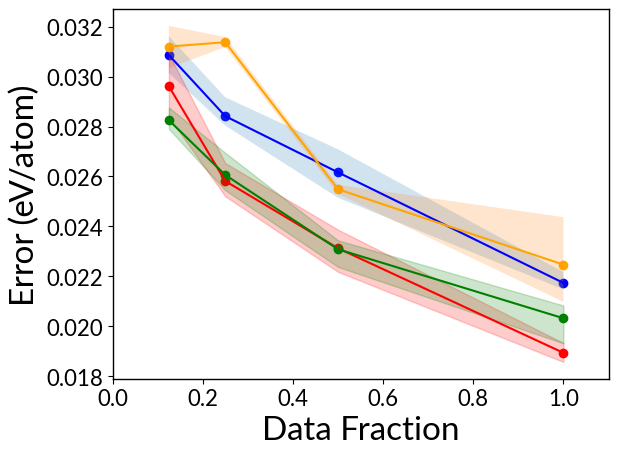

In [4]:
x_vals = [1.0,0.5,0.25,0.125]

fig, ax = plt.subplots()

ax.plot(x_vals,CGCNN[0],color="blue")
ax.scatter(x_vals,CGCNN[0],color="blue")
ax.fill_between(x_vals, CGCNN[0]-CGCNN[1], CGCNN[0]+CGCNN[2], alpha=0.2)

             
ax.plot(x_vals,CGCNN_interp[0],color="orange")
ax.scatter(x_vals,CGCNN_interp[0],color="orange")
ax.fill_between(x_vals, CGCNN_interp[0]-CGCNN_interp[1], CGCNN_interp[0]+CGCNN_interp[2], alpha=0.2)

             
ax.plot(x_vals,e3nn[0],color="red")
ax.scatter(x_vals,e3nn[0],color="red")
ax.fill_between(x_vals, e3nn[0]-e3nn[1], e3nn[0]+e3nn[2], alpha=0.2,color="red")


             
             
ax.plot(x_vals,e3nn_interp[0],color="green")
ax.scatter(x_vals,e3nn_interp[0],color="green")
ax.fill_between(x_vals, e3nn_interp[0]-e3nn_interp[1], e3nn_interp[0]+e3nn_interp[2], alpha=0.2,color="green")

plt.xlim(0.0,1.1)
plt.xlabel("Data Fraction",fontsize=24)
plt.ylabel("Error (eV/atom)",fontsize=24)

plt.show()

In [5]:
CGCNN,CGCNN_interp,e3nn,e3nn_interp = get_property("Op_band_center","unrelaxed")

{'data': 'data/', 'struct_type': 'unrelaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 1.0}
Op_band_center_htvs_data_unrelaxed_CGCNN
{'data': 'data/', 'struct_type': 'unrelaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 0.5}
Op_band_center_htvs_data_unrelaxed_CGCNN_TrainingFraction0.5
{'data': 'data/', 'struct_type': 'unrelaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 0.25}
Op_band_center_htvs_data_unrelaxed_CGCNN_TrainingFraction0.25
{'data': 'data/', 'struct_type': 'unrelaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 0.125}
Op_band_center_htvs_data_unrelaxed_CGCNN_TrainingFraction0.125
{'data': 'data/', 'struct_type': 'unrelaxed', 'interpolation': True, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 1.0}
Op_band_center_htvs_data_unrelaxed_interp

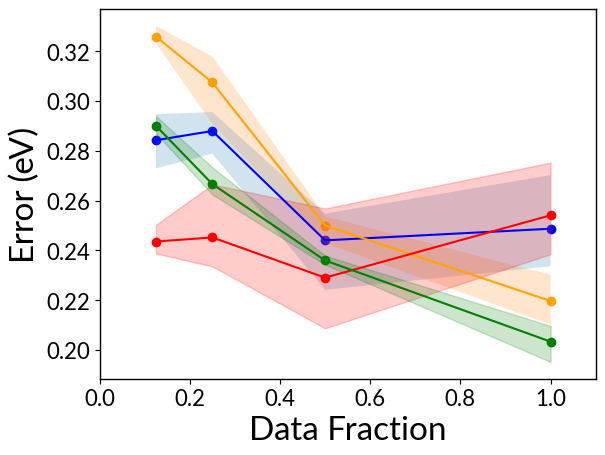

In [6]:
x_vals = [1.0,0.5,0.25,0.125]

fig, ax = plt.subplots()

ax.plot(x_vals,CGCNN[0],color="blue")
ax.scatter(x_vals,CGCNN[0],color="blue")
ax.fill_between(x_vals, CGCNN[0]-CGCNN[1], CGCNN[0]+CGCNN[2], alpha=0.2)

             
ax.plot(x_vals,CGCNN_interp[0],color="orange")
ax.scatter(x_vals,CGCNN_interp[0],color="orange")
ax.fill_between(x_vals, CGCNN_interp[0]-CGCNN_interp[1], CGCNN_interp[0]+CGCNN_interp[2], alpha=0.2)

             
ax.plot(x_vals,e3nn[0],color="red")
ax.scatter(x_vals,e3nn[0],color="red")
ax.fill_between(x_vals, e3nn[0]-e3nn[1], e3nn[0]+e3nn[2], alpha=0.2,color="red")


             
             
ax.plot(x_vals,e3nn_interp[0],color="green")
ax.scatter(x_vals,e3nn_interp[0],color="green")
ax.fill_between(x_vals, e3nn_interp[0]-e3nn_interp[1], e3nn_interp[0]+e3nn_interp[2], alpha=0.2,color="green")

plt.xlim(0.0,1.1)
plt.xlabel("Data Fraction",fontsize=24)
plt.ylabel("Error (eV)",fontsize=24)

plt.show()

In [7]:
CGCNN,CGCNN_interp,e3nn,e3nn_interp = get_property("dft_e_hull","relaxed")

{'data': 'data/', 'struct_type': 'relaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 1.0}
dft_e_hull_htvs_data_relaxed_CGCNN
{'data': 'data/', 'struct_type': 'relaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 0.5}
dft_e_hull_htvs_data_relaxed_CGCNN_TrainingFraction0.5
{'data': 'data/', 'struct_type': 'relaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 0.25}
dft_e_hull_htvs_data_relaxed_CGCNN_TrainingFraction0.25
{'data': 'data/', 'struct_type': 'relaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 0.125}
dft_e_hull_htvs_data_relaxed_CGCNN_TrainingFraction0.125
{'data': 'data/', 'struct_type': 'relaxed', 'interpolation': True, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 1.0}
dft_e_hull_htvs_data_relaxed_interpolation_CGCNN
{'data': 'data/', 'struct_

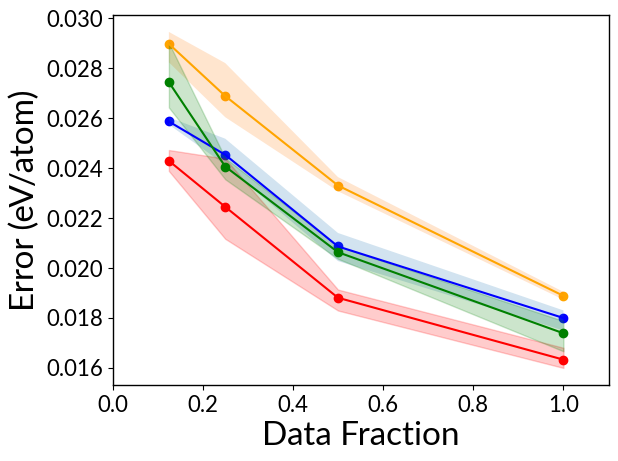

In [8]:
x_vals = [1.0,0.5,0.25,0.125]

fig, ax = plt.subplots()

ax.plot(x_vals,CGCNN[0],color="blue")
ax.scatter(x_vals,CGCNN[0],color="blue")
ax.fill_between(x_vals, CGCNN[0]-CGCNN[1], CGCNN[0]+CGCNN[2], alpha=0.2)

             
ax.plot(x_vals,CGCNN_interp[0],color="orange")
ax.scatter(x_vals,CGCNN_interp[0],color="orange")
ax.fill_between(x_vals, CGCNN_interp[0]-CGCNN_interp[1], CGCNN_interp[0]+CGCNN_interp[2], alpha=0.2)

             
ax.plot(x_vals,e3nn[0],color="red")
ax.scatter(x_vals,e3nn[0],color="red")
ax.fill_between(x_vals, e3nn[0]-e3nn[1], e3nn[0]+e3nn[2], alpha=0.2,color="red")


             
             
ax.plot(x_vals,e3nn_interp[0],color="green")
ax.scatter(x_vals,e3nn_interp[0],color="green")
ax.fill_between(x_vals, e3nn_interp[0]-e3nn_interp[1], e3nn_interp[0]+e3nn_interp[2], alpha=0.2,color="green")

plt.xlim(0.0,1.1)
plt.xlabel("Data Fraction",fontsize=24)
plt.ylabel("Error (eV/atom)",fontsize=24)

plt.show()

In [9]:
CGCNN,CGCNN_interp,e3nn,e3nn_interp = get_property("Op_band_center","relaxed")

{'data': 'data/', 'struct_type': 'relaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 1.0}
Op_band_center_htvs_data_relaxed_CGCNN
{'data': 'data/', 'struct_type': 'relaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 0.5}
Op_band_center_htvs_data_relaxed_CGCNN_TrainingFraction0.5
{'data': 'data/', 'struct_type': 'relaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 0.25}
Op_band_center_htvs_data_relaxed_CGCNN_TrainingFraction0.25
{'data': 'data/', 'struct_type': 'relaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 0.125}
Op_band_center_htvs_data_relaxed_CGCNN_TrainingFraction0.125
{'data': 'data/', 'struct_type': 'relaxed', 'interpolation': True, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 1.0}
Op_band_center_htvs_data_relaxed_interpolation_CGCNN
{'data

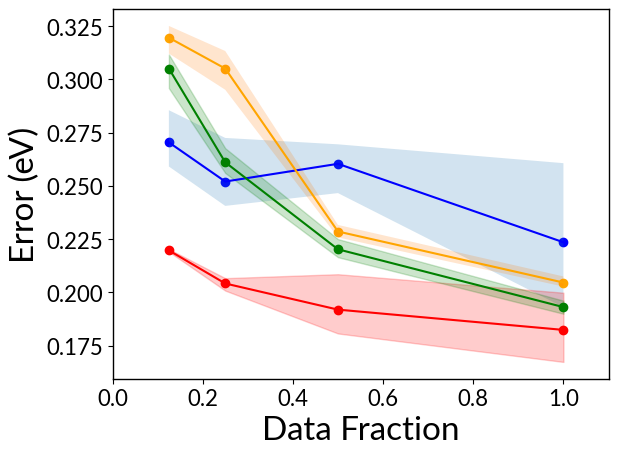

In [10]:
x_vals = [1.0,0.5,0.25,0.125]

fig, ax = plt.subplots()

ax.plot(x_vals,CGCNN[0],color="blue")
ax.scatter(x_vals,CGCNN[0],color="blue")
ax.fill_between(x_vals, CGCNN[0]-CGCNN[1], CGCNN[0]+CGCNN[2], alpha=0.2)

             
ax.plot(x_vals,CGCNN_interp[0],color="orange")
ax.scatter(x_vals,CGCNN_interp[0],color="orange")
ax.fill_between(x_vals, CGCNN_interp[0]-CGCNN_interp[1], CGCNN_interp[0]+CGCNN_interp[2], alpha=0.2)

             
ax.plot(x_vals,e3nn[0],color="red")
ax.scatter(x_vals,e3nn[0],color="red")
ax.fill_between(x_vals, e3nn[0]-e3nn[1], e3nn[0]+e3nn[2], alpha=0.2,color="red")


             
             
ax.plot(x_vals,e3nn_interp[0],color="green")
ax.scatter(x_vals,e3nn_interp[0],color="green")
ax.fill_between(x_vals, e3nn_interp[0]-e3nn_interp[1], e3nn_interp[0]+e3nn_interp[2], alpha=0.2,color="green")

plt.xlim(0.0,1.1)
plt.xlabel("Data Fraction",fontsize=24)
plt.ylabel("Error (eV)",fontsize=24)

plt.show()